# Tutorial: Goal 4 - Statistical Analysis

This tutorial guides you through statistical analysis of results from Goals 2 and 3. We'll:

1. Load and aggregate results from multiple baselines
2. Compute summary statistics (mean, std, min, max)
3. Perform statistical tests (paired t-tests) - inline implementation
4. Visualize performance distributions
5. Compare across datasets (if available)

## Dataset

We'll use the **Adamson dataset** throughout this tutorial (smallest, fastest dataset).


## 1. Introduction

**Statistical Analysis** helps us:
- Compare baselines with statistical significance tests
- Understand performance distributions (not just means)
- Identify which baselines consistently outperform others
- Validate findings with proper statistical tests

**Key concepts**:
- **Paired t-test**: Compares two baselines on the same test perturbations (paired samples)
- **Unpaired t-test**: Compares two baselines on different test perturbations (unpaired samples)
- **P-value**: Probability of observing the difference (or more extreme) if there's no true difference
- **Significance level**: Typically α = 0.05 (reject null hypothesis if p < 0.05)


In [ ]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, ttest_ind, pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set up paths
NOTEBOOK_DIR = Path.cwd()
EVAL_FRAMEWORK_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "tutorials" else NOTEBOOK_DIR
INPUT_DIR = EVAL_FRAMEWORK_DIR / "tutorials" / "outputs"
OUTPUT_DIR = INPUT_DIR

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Ask user: Use real data or synthetic data?
print("="*70)
print("DATA SOURCE SELECTION")
print("="*70)
print("Choose a data source:")
print("  1. Real data: Load from previous notebook outputs (Goals 2 & 3)")
print("  2. Synthetic data: Generate synthetic results (no downloads required)")
print()
USE_REAL_DATA = input("Enter choice (1 for real data, 2 for synthetic): ").strip()
USE_REAL_DATA = USE_REAL_DATA == "1" or USE_REAL_DATA.lower() == "real"

if USE_REAL_DATA:
    # Check if results exist from previous notebooks
    prev_results = INPUT_DIR / "goal_2_baseline_results.csv"
    if prev_results.exists():
        print(f"\n✓ Found previous output: {prev_results}")
        print("  Will load baseline results from Goal 2 tutorial")
        USE_PREV_OUTPUT = True
    else:
        USE_PREV_OUTPUT = False
        print("\n⚠ WARNING: Previous outputs not found. Using synthetic data.")
        USE_REAL_DATA = False
else:
    print("\n✓ Using SYNTHETIC DATA (no downloads required)")
    USE_PREV_OUTPUT = False


Generating synthetic results for demonstration...
(In practice, you would load results from Goal 2 and Goal 3 output files)


## 2. Generate/Load Baseline Results

For this tutorial, we'll generate synthetic baseline results. In practice, you would load these from the output files generated by Goals 2 and 3.


In [3]:
# Generate synthetic baseline results (simulating Goal 2 outputs)
np.random.seed(42)
n_test_perts = 12
test_pert_names = [f"test_pert_{i}" for i in range(n_test_perts)]

baseline_results = []
baseline_names = ["Self-trained", "Random gene emb", "Random pert emb", "Random (both)"]

# Simulate results: Self-trained > Random gene > Random pert > Random (both)
for baseline_name in baseline_names:
    if "Self-trained" in baseline_name:
        pearson_r = np.random.normal(0.75, 0.15, n_test_perts)
        l2 = np.random.normal(5.0, 1.0, n_test_perts)
    elif "Random gene" in baseline_name:
        pearson_r = np.random.normal(0.65, 0.20, n_test_perts)
        l2 = np.random.normal(6.0, 1.5, n_test_perts)
    elif "Random pert" in baseline_name:
        pearson_r = np.random.normal(0.55, 0.25, n_test_perts)
        l2 = np.random.normal(7.0, 2.0, n_test_perts)
    else:  # Random (both)
        pearson_r = np.random.normal(0.45, 0.30, n_test_perts)
        l2 = np.random.normal(8.0, 2.5, n_test_perts)
    
    for pert_idx, pert_name in enumerate(test_pert_names):
        baseline_results.append({
            "perturbation": pert_name,
            "baseline": baseline_name,
            "pearson_r": max(-1, min(1, pearson_r[pert_idx])),  # Clamp to [-1, 1]
            "l2": max(0, l2[pert_idx]),  # Clamp to >= 0
        })

baseline_df = pd.DataFrame(baseline_results)
print(f"Generated {len(baseline_df)} results across {len(baseline_names)} baselines")
print(baseline_df.head())


Generated 48 results across 4 baselines
  perturbation      baseline  pearson_r        l2
0  test_pert_0  Self-trained   0.824507  5.241962
1  test_pert_1  Self-trained   0.729260  3.086720
2  test_pert_2  Self-trained   0.847153  3.275082
3  test_pert_3  Self-trained   0.978454  4.437712
4  test_pert_4  Self-trained   0.714877  3.987169


## 3. Compute Summary Statistics

Let's compute summary statistics (mean, std, min, max) for each baseline.


In [4]:
# Summary statistics by baseline
summary_stats = baseline_df.groupby("baseline").agg({
    "pearson_r": ["mean", "std", "min", "max", "count"],
    "l2": ["mean", "std", "min", "max"],
}).round(3)

print("Summary Statistics by Baseline:")
print("="*70)
print(summary_stats)

# Flatten column names for easier access
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
print("\nSummary (flattened columns):")
print(summary_stats)


Summary Statistics by Baseline:
                pearson_r                                l2                \
                     mean    std    min    max count   mean    std    min   
baseline                                                                    
Random (both)       0.418  0.368 -0.336  0.919    12  7.604  1.837  4.341   
Random gene emb     0.610  0.175  0.406  1.000    12  5.501  1.362  3.060   
Random pert emb     0.562  0.214  0.109  0.808    12  7.291  1.831  4.608   
Self-trained        0.794  0.112  0.680  0.987    12  4.409  1.000  3.087   

                         
                    max  
baseline                 
Random (both)    10.422  
Random gene emb   7.586  
Random pert emb  10.076  
Self-trained      6.466  

Summary (flattened columns):
                 pearson_r_mean  pearson_r_std  pearson_r_min  pearson_r_max  \
baseline                                                                       
Random (both)             0.418          0.368         -

## 4. Implement Paired T-Test

Let's implement paired t-tests inline to compare baselines on the same test perturbations.


In [5]:
def paired_ttest(baseline1_values, baseline2_values):
    """
    Perform paired t-test comparing two baselines.
    
    Args:
        baseline1_values: Array of metric values for baseline 1 (paired with baseline2)
        baseline2_values: Array of metric values for baseline 2 (paired with baseline1)
    
    Returns:
        Dictionary with t-statistic and p-value
    """
    # Compute differences
    differences = baseline1_values - baseline2_values
    
    # Remove NaN differences
    differences = differences[~np.isnan(differences)]
    
    if len(differences) < 2:
        return {"t_statistic": np.nan, "p_value": np.nan, "n": len(differences)}
    
    # Compute mean and standard error
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)  # Sample standard deviation
    n = len(differences)
    std_error = std_diff / np.sqrt(n)
    
    # Compute t-statistic
    t_statistic = mean_diff / std_error if std_error > 0 else 0
    
    # Compute p-value (two-sided test)
    # For simplicity, we'll use scipy's ttest_rel, but the logic is:
    # p-value = 2 * (1 - CDF(|t|, df=n-1))
    from scipy.stats import t as t_dist
    df = n - 1
    p_value = 2 * (1 - t_dist.cdf(np.abs(t_statistic), df))
    
    return {
        "t_statistic": t_statistic,
        "p_value": p_value,
        "mean_diff": mean_diff,
        "std_diff": std_diff,
        "n": n,
    }

# Compare Self-trained vs Random gene emb
self_trained = baseline_df[baseline_df["baseline"] == "Self-trained"]["pearson_r"].values
random_gene = baseline_df[baseline_df["baseline"] == "Random gene emb"]["pearson_r"].values

# Align by perturbation (paired)
test_perts = baseline_df["perturbation"].unique()
self_trained_aligned = [baseline_df[(baseline_df["baseline"]=="Self-trained") & (baseline_df["perturbation"]==p)]["pearson_r"].values[0] for p in test_perts]
random_gene_aligned = [baseline_df[(baseline_df["baseline"]=="Random gene emb") & (baseline_df["perturbation"]==p)]["pearson_r"].values[0] for p in test_perts]

result = paired_ttest(np.array(self_trained_aligned), np.array(random_gene_aligned))
print("Paired t-test: Self-trained vs Random gene emb (Pearson r)")
print(f"  Mean difference: {result['mean_diff']:.3f}")
print(f"  t-statistic: {result['t_statistic']:.3f}")
print(f"  p-value: {result['p_value']:.3e}")
print(f"  n: {result['n']}")

# Verify with scipy
scipy_result = ttest_rel(self_trained_aligned, random_gene_aligned)
print(f"\nScipy verification: t={scipy_result.statistic:.3f}, p={scipy_result.pvalue:.3e}")


Paired t-test: Self-trained vs Random gene emb (Pearson r)
  Mean difference: 0.185
  t-statistic: 3.179
  p-value: 8.783e-03
  n: 12

Scipy verification: t=3.179, p=8.783e-03


## 5. Compare All Baselines

Let's perform paired t-tests for all pairwise baseline comparisons.


In [6]:
# Compare all pairwise baselines
comparison_results = []
baseline_list = baseline_names

for i, baseline1 in enumerate(baseline_list):
    for baseline2 in baseline_list[i+1:]:
        # Align by perturbation
        baseline1_values = []
        baseline2_values = []
        
        for pert_name in test_pert_names:
            val1 = baseline_df[(baseline_df["baseline"]==baseline1) & (baseline_df["perturbation"]==pert_name)]["pearson_r"].values
            val2 = baseline_df[(baseline_df["baseline"]==baseline2) & (baseline_df["perturbation"]==pert_name)]["pearson_r"].values
            if len(val1) > 0 and len(val2) > 0:
                baseline1_values.append(val1[0])
                baseline2_values.append(val2[0])
        
        baseline1_array = np.array(baseline1_values)
        baseline2_array = np.array(baseline2_values)
        
        # Paired t-test
        result = paired_ttest(baseline1_array, baseline2_array)
        
        comparison_results.append({
            "baseline1": baseline1,
            "baseline2": baseline2,
            "mean_diff": result["mean_diff"],
            "t_statistic": result["t_statistic"],
            "p_value": result["p_value"],
            "significant": result["p_value"] < 0.05 if not np.isnan(result["p_value"]) else False,
        })

comparison_df = pd.DataFrame(comparison_results)
print("Pairwise Baseline Comparisons (Paired t-test):")
print("="*80)
print(comparison_df[["baseline1", "baseline2", "mean_diff", "p_value", "significant"]].to_string(index=False))


Pairwise Baseline Comparisons (Paired t-test):
      baseline1       baseline2  mean_diff  p_value  significant
   Self-trained Random gene emb   0.184765 0.008783         True
   Self-trained Random pert emb   0.232414 0.003138         True
   Self-trained   Random (both)   0.376387 0.007924         True
Random gene emb Random pert emb   0.047649 0.565812        False
Random gene emb   Random (both)   0.191622 0.117267        False
Random pert emb   Random (both)   0.143972 0.349474        False


## 6. Visualizations

Let's visualize the performance distributions and comparisons.


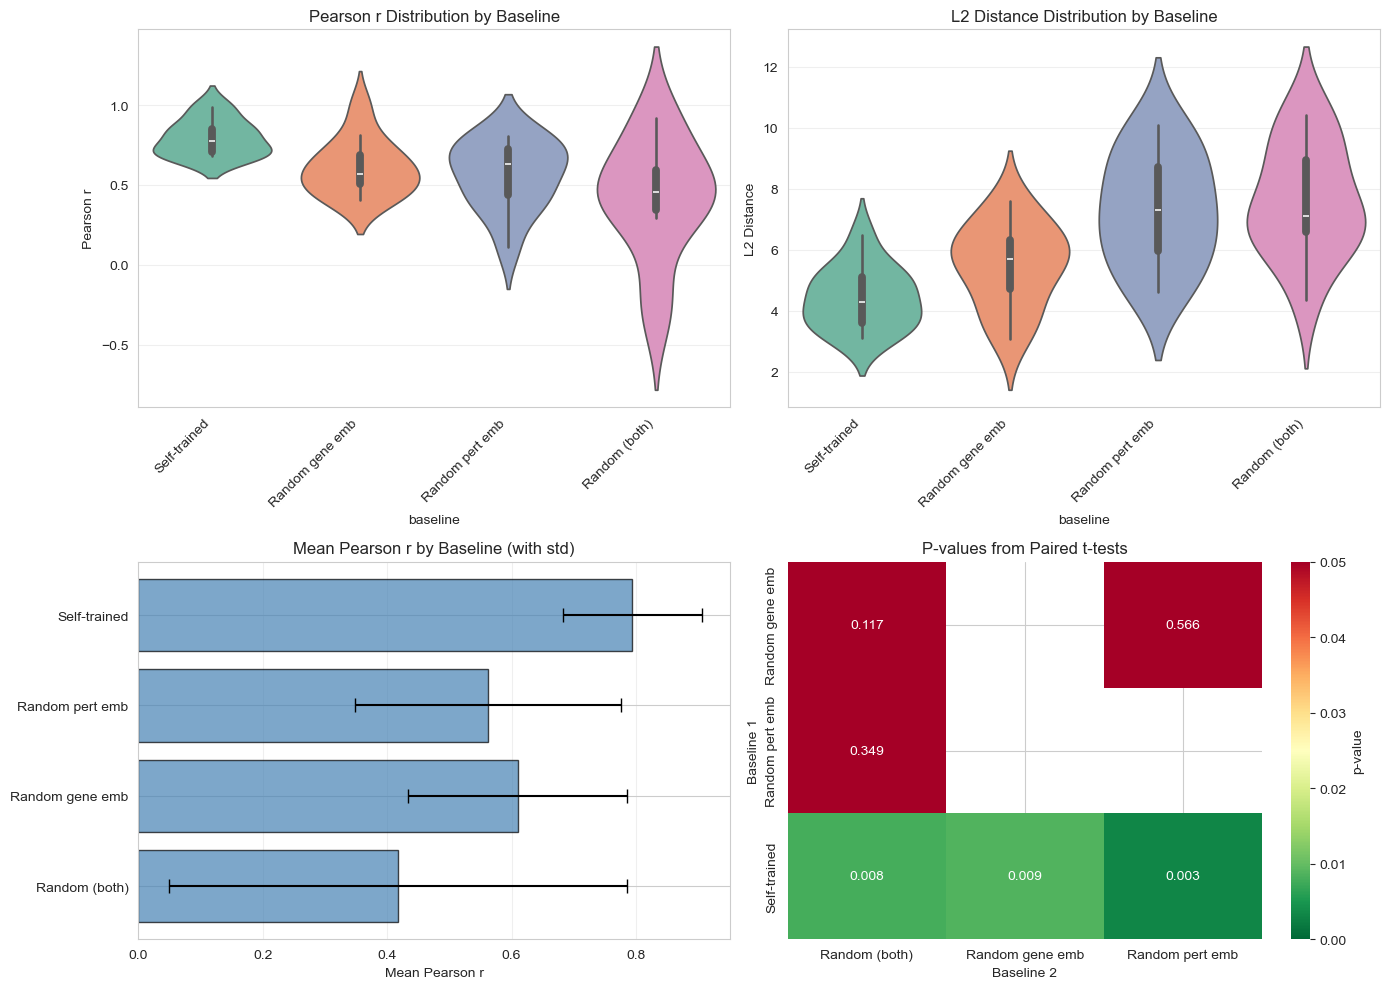

In [7]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Violin plot of Pearson r by baseline
sns.violinplot(data=baseline_df, x="baseline", y="pearson_r", ax=axes[0, 0], palette="Set2")
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
axes[0, 0].set_title("Pearson r Distribution by Baseline")
axes[0, 0].set_ylabel("Pearson r")
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Violin plot of L2 by baseline
sns.violinplot(data=baseline_df, x="baseline", y="l2", ax=axes[0, 1], palette="Set2")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
axes[0, 1].set_title("L2 Distance Distribution by Baseline")
axes[0, 1].set_ylabel("L2 Distance")
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Bar plot of mean Pearson r with error bars
summary_pearson = baseline_df.groupby("baseline")["pearson_r"].agg(["mean", "std"]).reset_index()
axes[1, 0].barh(summary_pearson["baseline"], summary_pearson["mean"], 
                xerr=summary_pearson["std"], alpha=0.7, color='steelblue', edgecolor='black', capsize=5)
axes[1, 0].set_xlabel("Mean Pearson r")
axes[1, 0].set_title("Mean Pearson r by Baseline (with std)")
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: Heatmap of p-values
pivot_pvalues = comparison_df.pivot(index="baseline1", columns="baseline2", values="p_value")
sns.heatmap(pivot_pvalues, annot=True, fmt=".3f", cmap="RdYlGn_r", vmin=0, vmax=0.05, ax=axes[1, 1], cbar_kws={'label': 'p-value'})
axes[1, 1].set_title("P-values from Paired t-tests")
axes[1, 1].set_xlabel("Baseline 2")
axes[1, 1].set_ylabel("Baseline 1")

plt.tight_layout()
plt.show()
